In [1]:
import ROOT
import math 
import time
import os
import numpy as np
from array import array
import uproot
import pandas as pd

Welcome to JupyROOT 6.22/02


In [2]:
# Get input TTree
dir_in = '/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts/'

DFs = {}

file_in = dir_in + 'outputs/Run23Call_VBFall.root'
the_tree = uproot.open(file_in)['VBFNanoAOD/VBFtree']
df = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in)

DFs['23C'] = df

file_in1 = dir_in + 'outputs/Run23Dall_VBFall.root'
the_tree1 = uproot.open(file_in1)['VBFNanoAOD/VBFtree']
df1 = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in1)


DFs['23D'] = df1


file_in2 = dir_in + 'outputs/Run23all_VBFall.root'
the_tree2 = uproot.open(file_in2)['VBFNanoAOD/VBFtree']
df2 = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in2)


DFs['23all'] = df2

file_in3 = dir_in + 'VBFinv_Summer23_histo.root'
the_tree3 = uproot.open(file_in3)['VBFNanoAOD/VBFtree']
df3 = ROOT.RDataFrame('VBFNanoAOD/VBFtree',file_in3)


DFs['23mc'] = df3



In [3]:
# mjj from 2 jets
ROOT.gInterpreter.Declare(
'''
float get_mjj_dumb(float pt1, float eta1, float phi1,
                   float pt2, float eta2, float phi2) {
              
    ROOT::Math::PtEtaPhiMVector p1(pt1, eta1, phi1, 0.);
    ROOT::Math::PtEtaPhiMVector p2(pt2, eta2, phi2, 0.);
    return (p1+p2).mass();
}
'''
)

# highest mjj among all jet pairs (with pT>60 GeV, id tight) + additional variables for VBF jets
ROOT.gInterpreter.Declare('''
float get_VBF_var(TString var,
                  ROOT::VecOps::RVec<Float_t> pt,
                  ROOT::VecOps::RVec<Float_t> eta,
                  ROOT::VecOps::RVec<Float_t> phi,
                  ROOT::VecOps::RVec<Float_t> id,
                  ROOT::VecOps::RVec<Float_t> chf,
                  Float_t pt1cut,
                  Float_t pt2cut,
                  Float_t idcut,
                  Bool_t CHFcut) {
    
    Double_t mjj      = -1;
    Double_t detajj   = -1;
    Double_t etabest  = -999;
    Double_t etabest2 = -999;
    Double_t ptbest  = -999;
    Double_t ptbest2 = -999;
    Double_t chfbest  = -1;
    Double_t chfbest2 = -1;
    
    const auto size = pt.size();
    for (size_t idx1=0; idx1<size; ++idx1){
        for (size_t idx2=0; idx2<idx1; ++idx2){
        
            if (pt[idx1]<pt2cut || pt[idx2]<pt2cut)
                continue;
            if (id[idx1]<idcut || id[idx2]<idcut)
                continue;
            if (CHFcut && ((abs(eta[idx1])<2.5 && chf[idx1]<0.3) ||
                           (abs(eta[idx2])<2.5 && chf[idx2]<0.3)   ))
                continue;
            ROOT::Math::PtEtaPhiMVector p1(pt[idx1], eta[idx1], phi[idx1], 0.);
            ROOT::Math::PtEtaPhiMVector p2(pt[idx2], eta[idx2], phi[idx2], 0.);
            
            if ((p1+p2).mass() > mjj
               && ((p1.pt()>pt1cut && p2.pt()>pt2cut) || (p1.pt()>pt2cut && p2.pt()>pt2cut && p1.pt()<pt1cut && pt[0]>pt1cut))
               //&& ((p1.pt()>pt1cut && p2.pt()>pt2cut) || (p1.pt()>pt2cut && p2.pt()>pt1cut))
               //&& (chf[idx1]>0.3||abs(p1.eta())>2.5) && (chf[idx2]>0.3||abs(p2.eta())>2.5)
               ) {
                mjj      = (p1+p2).mass();
                detajj   = abs(eta[idx1]-eta[idx2]);
                etabest  = (p1.pt()>p2.pt()) ? p1.eta():p2.eta();
                etabest2 = (p1.pt()>p2.pt()) ? p2.eta():p1.eta();
                ptbest   = (p1.pt()>p2.pt()) ? p1.pt():p2.pt();
                ptbest2  = (p1.pt()>p2.pt()) ? p2.pt():p1.pt();
                chfbest  = (p1.pt()>p2.pt()) ? chf[idx1]:chf[idx2];
                chfbest2 = (p1.pt()>p2.pt()) ? chf[idx2]:chf[idx1];
            }
        }
    }
    if (var=="mjj") 
        return mjj;
    if (var=="detajj")
        return detajj;
    if (var=="eta")
        return etabest;
    if (var=="eta2")
        return etabest2;
    if (var=="pt")
        return ptbest;
    if (var=="pt2")
        return ptbest2;
    if (var=="chf")
        return chfbest;
    if (var=="chf2")
        return chfbest2;
        
    return -999.;
}
'''
)

True

In [4]:
# checking cuts to measure eff vs mjj
ROOT.gInterpreter.Declare('''
bool pass_jet_cuts_forMjj(ROOT::VecOps::RVec<Float_t> pt,
                   ROOT::VecOps::RVec<Float_t> eta,
                   ROOT::VecOps::RVec<Float_t> phi,
                   ROOT::VecOps::RVec<Float_t> id,
                   ROOT::VecOps::RVec<Float_t> chf,
                   Float_t pt1cut,
                   Float_t pt2cut,
                   Float_t detajjcut,
                   Bool_t CHFcut) {
                   
    Bool_t pass = true;
    pass = pass && (pt[0]>pt1cut);
    pass = pass && (pt[1]>pt2cut);
    pass = pass && (get_VBF_var("detajj",pt,eta,phi,id,chf,pt1cut, pt2cut,6,CHFcut)>detajjcut);
    return pass;
}
''')


# checking cuts to measure eff vs mjj
ROOT.gInterpreter.Declare('''
Double_t get_METnoMu(ROOT::VecOps::RVec<Float_t> mu_pt,
                     ROOT::VecOps::RVec<Float_t> mu_phi,
                     Float_t MET_et,
                     Float_t MET_phi) {
                     
    ROOT::Math::PtEtaPhiMVector METnoMu(MET_et, 0, MET_phi, 0.);
    const auto size = mu_pt.size();
    for (size_t idx1=0; idx1<size; ++idx1){
        ROOT::Math::PtEtaPhiMVector mu(mu_pt[idx1], 0, mu_phi[idx1], 0.);
        METnoMu+=mu;
    }
    return METnoMu.pt();
}
''')

True

In [5]:
# checking cuts to measure eff vs mjj
ROOT.gInterpreter.Declare('''
bool pass_VBF_cuts(TString plotvar,
                   ROOT::VecOps::RVec<Float_t> pt,
                   ROOT::VecOps::RVec<Float_t> eta,
                   ROOT::VecOps::RVec<Float_t> phi,
                   ROOT::VecOps::RVec<Float_t> id,
                   ROOT::VecOps::RVec<Float_t> chf,
                   Float_t pt1cut,
                   Float_t pt2cut,
                   Float_t mjjcut,
                   Float_t detajjcut,
                   Bool_t CHFcut) {
                   
    Bool_t pass = true; 
    pass = pass && (pt[0]>pt1cut || plotvar=="pt1");
    pass = pass && (pt[1]>pt2cut || plotvar=="pt2" || plotvar=="pt1");
    pass = pass && (detajjcut < get_VBF_var("detajj",
                                pt, eta, phi, id, chf,
                                pt1cut, pt2cut,6,CHFcut) 
                    || plotvar=="detajj");
    pass = pass && (mjjcut < get_VBF_var("mjj", 
                                         pt,eta,phi,id,chf,
                                         pt1cut,pt2cut,6,CHFcut)
                    || plotvar=="mjj");


    return pass;
}
''')

True

In [6]:
def fill_eff(h_num, h_den, year,var,version):
    eff = ROOT.TGraphAsymmErrors(h_num[year][var][version].GetValue(),
                                 h_den[year][var].GetValue(),
                                 'eff_{}'.format(var))
    return eff


def redrawBorder():
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()
    l = ROOT.TLine()
    l.SetLineWidth(2)
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin())

def print_unique_runs(df):
    df_runs = df.AsNumpy(["run"])
    np.unique(df_runs['run'])
    for run in np.unique(df_runs['run']):
        print(run)

In [7]:
print_unique_runs(DFs['23C'])

367661.0
367662.0
367663.0
367665.0
367666.0
367691.0
367696.0
367699.0
367730.0
367742.0
367758.0
367770.0
367771.0
367772.0
367790.0
367831.0
367836.0
367838.0
367840.0
367881.0
367883.0
367884.0
367902.0
367904.0
367905.0
367906.0
367907.0
367908.0
367910.0
368223.0
368224.0


In [8]:
print_unique_runs(DFs['23D'])

370293.0
370294.0
370300.0
370304.0
370307.0
370321.0
370332.0
370340.0
370354.0


In [9]:
#periods = ["23C","23D","23all","23mc"]
periods = ["23all","23mc"]

#pass_cuts_for_mjj = 'pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,135.,55.,1000,3.8, false)'
get_mjj_dumb = 'get_mjj_dumb(jets_pt[0],jets_eta[0],jets_phi[0],jets_pt[1],jets_eta[1],jets_phi[1])'

df_mjj_all = {}
# apply basic filter & evaluate variables
for year in periods:
    df_mjj_all[year] = DFs[year]\
                    .Define('mjjdumb', get_mjj_dumb)\
                    .Define('chf1',    'jets_CHF[0]')\
                    .Define('chf2',    'jets_CHF[1]')\
                    .Define('chf3',    'jets_CHF[2]')\
                    .Define('METnoMu', 'get_METnoMu(mu_pt,mu_phi,MET_et,MET_phi)')\
                    .Define('mjj2',    'get_VBF_var("mjj", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('chfbest', 'get_VBF_var("chf", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('chfbest2','get_VBF_var("chf2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('etabest', 'get_VBF_var("eta", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('etabest2','get_VBF_var("eta2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('ptbest',  'get_VBF_var("pt", jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('ptbest2', 'get_VBF_var("pt2",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,115.,50.,6, false)')\
                    .Define('Detajj',  'abs(etabest-etabest2)')

In [10]:
df_mjj_den = {}
df_mjj_numL1 = {}
df_mjj_num = {}
df_mjj_numOld = {}
for year in periods:
    df_mjj_den[year] = df_mjj_all[year]

    # apply additional filters
    #df_mjj_den = df_mjj_den.Filter('MET_et>200')
    #df_mjj_den[year] = df_mjj_den[year].Filter('mjj2>800. && MET_et>200.')

    df_mjj_numL1[year]  = df_mjj_den[year].Filter('passL1VBFmet')
    df_mjj_num[year]    = df_mjj_den[year].Filter('passVBFmet_2j || passVBFmet_3j')
    df_mjj_numOld[year] = df_mjj_den[year].Filter('passVBFmet_old_2j || passVBFmet_old_3j')

In [56]:
### MET trigger plots

df_den = {}#df_mjj_all
df_num = {}#df_mjj_all

# define some filters and variables

#23C thresholds
#pass_cuts_for_mjj = 'METnoMu>200. ' + \
#                    '&& Detajj>3.5 ' + \
#                    '&& pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,85.,50.,550,3.5, false)'
#pass_cuts_for_detajj = 'METnoMu>200. && pass_VBF_cuts("detajj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,85.,50.,550,3.5, false)'
#pass_cuts_for_MET = 'mjj2>550. && Detajj>3.5 && pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,85.,50.,550,3.5, false)'

#23D thresholds
pass_cuts_for_mjj = 'METnoMu>200. ' + \
                    '&& Detajj>3.5 ' + \
                    '&& pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,90.,55.,550,3.5, false)'
#pass_cuts_for_mjj = 'METnoMu>200. ' + \
#                    '&& Detajj>3.5 ' + \
#                    '&& pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,85.,50.,550,3.5, false)'
pass_cuts_for_detajj = 'METnoMu>200. && pass_VBF_cuts("detajj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,90.,55.,550,3.5, false)'
pass_cuts_for_MET = 'mjj2>550. && Detajj>3.5 && pass_VBF_cuts("mjj",jets_pt,jets_eta,jets_phi,jets_id,jets_CHF,90.,55.,550,3.5, false)'


for year in periods:
    df_den[year] = {}
    df_den[year]['mjj'] = df_mjj_all[year].Filter(pass_cuts_for_mjj)
    df_den[year]['detajj'] = df_mjj_all[year].Filter(pass_cuts_for_detajj)
    df_den[year]['MET'] = df_mjj_all[year].Filter(pass_cuts_for_MET) 
    
    df_num[year] = { 'mjj' : {}, 'detajj' : {}, 'MET' : {} }
    df_num[year]['mjj']['new'] = df_den[year]['mjj'].Filter('passVBFmet_2j || passVBFmet_3j')
    df_num[year]['mjj']['old'] = df_den[year]['mjj'].Filter('passVBFmet_old_2j || passVBFmet_old_3j')
    df_num[year]['mjj']['L1']  = df_den[year]['mjj'].Filter('passL1VBFmet')
    #df_num[year]['mjj']['L1']  = df_den[year]['mjj'].Filter('passL1VBFmu')
    
    df_num[year]['detajj']['new'] = df_den[year]['detajj'].Filter('passVBFmet_2j || passVBFmet_3j')
    df_num[year]['detajj']['old'] = df_den[year]['detajj'].Filter('passVBFmet_old_2j || passVBFmet_old_3j')
    df_num[year]['detajj']['L1']  = df_den[year]['detajj'].Filter('passL1VBFmet')
    
    df_num[year]['MET']['new'] = df_den[year]['MET'].Filter('passVBFmet_2j || passVBFmet_3j')
    df_num[year]['MET']['old'] = df_den[year]['MET'].Filter('passVBFmet_old_2j || passVBFmet_old_3j')
    df_num[year]['MET']['L1']  = df_den[year]['MET'].Filter('passL1VBFmet')


#hist from DF    
    
h_den = {}
h_num = {}
for year in periods:
    h_num[year] = {'mjj' : {}, 'detajj' : {}, 'MET' : {} }
    h_den[year] = {}
    h_den[year]['mjj'] = df_den[year]['mjj'].Histo1D(    ('h_den','',   15,0,2500),'mjj2')
    h_num[year]['mjj'] = {
        'new': df_num[year]['mjj']['new'].Histo1D(    ('h_num_new','',   15,0,2500),'mjj2'),
        'old': df_num[year]['mjj']['old'].Histo1D(    ('h_num_old','',   15,0,2500),'mjj2'),
        'L1':  df_num[year]['mjj']['L1'].Histo1D(     ('h_num_l1','',    15,0,2500),'mjj2'),
    }
    
    
    h_den[year]['detajj'] = df_den[year]['detajj'].Histo1D(    ('h_den','',   15,0,10),'detajj')
    h_num[year]['detajj'] = {
        'new': df_num[year]['detajj']['new'].Histo1D(    ('h_num_new','',   15,0,10),'detajj'),
        'old': df_num[year]['detajj']['old'].Histo1D(    ('h_num_old','',   15,0,10),'detajj'),
        'L1':  df_num[year]['detajj']['L1'].Histo1D(     ('h_num_l1','',    15,0,10),'detajj'),
    }

    h_den[year]['MET'] = df_den[year]['MET'].Histo1D(    ('h_den','',   15,0,400),'METnoMu')
    h_num[year]['MET'] = {
        'new': df_num[year]['MET']['new'].Histo1D(    ('h_num_new','',   15,0,400),'METnoMu'),
        'old': df_num[year]['MET']['old'].Histo1D(    ('h_num_old','',   15,0,400),'METnoMu'),
        'L1':  df_num[year]['MET']['L1'].Histo1D(     ('h_num_l1','',    15,0,400),'METnoMu'),
    }

Eff = {}
for year in periods:
    Eff[year] = {'mjj' : {}, 'detajj' : {}, 'MET' : {} }
    
    Eff[year]['mjj']['new']    = fill_eff(h_num, h_den, year, 'mjj', 'new')
    Eff[year]['mjj']['old']    = fill_eff(h_num, h_den, year, 'mjj', 'old')
    Eff[year]['mjj']['L1']     = fill_eff(h_num, h_den, year, 'mjj', 'L1' )
    
    Eff[year]['detajj']['new'] = fill_eff(h_num, h_den, year, 'detajj', 'new')
    Eff[year]['detajj']['old'] = fill_eff(h_num, h_den, year, 'detajj', 'old')
    Eff[year]['detajj']['L1']  = fill_eff(h_num, h_den, year, 'detajj', 'L1' )
    
    Eff[year]['MET']['new']    = fill_eff(h_num, h_den, year, 'MET', 'new')
    Eff[year]['MET']['old']    = fill_eff(h_num, h_den, year, 'MET', 'old')
    Eff[year]['MET']['L1']     = fill_eff(h_num, h_den, year, 'MET', 'L1')

In [63]:
# Definingvariables, categories & cuts

jet_vars = ['pt1','pt2','mjj','detajj']

trigs = ['VBFincl','VBFjets','VBFmet' ,'VBFphot','VBFele' ,'VBFmu'  ,'VBFtau']

jet_cuts = {
        'VBFincl' : {"pt1": 115, "pt2":50, "mjj":1200, "detajj":3.8},
        'VBFjets' : {"pt1": 80,  "pt2":50, "mjj":800,  "detajj":2.8},
        'VBFmet'  : {"pt1": 85,  "pt2":50, "mjj":550,  "detajj":3.5},
        'VBFphot' : {"pt1": 55,  "pt2":55, "mjj":700,  "detajj":2.8},
        'VBFele'  : {"pt1": 55,  "pt2":55, "mjj":700,  "detajj":2.8},
        'VBFmu'   : {"pt1": 100, "pt2":50, "mjj":800,  "detajj":2.8},
        'VBFtau'  : {"pt1": 55,  "pt2":55, "mjj":700,  "detajj":2.8},
}

cut_str = {
    'mjj'    : 'detajj > {detajjcut} && pt2 > {pt2cut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
    'pt1'    : 'detajj > {detajjcut} && pt2 > {pt2cut} && mjj > {mjjcut}',
    'pt2'    : 'detajj > {detajjcut} && mjj > {mjjcut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
    'detajj' : 'mjj > {mjjcut} && pt2 > {pt2cut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
    'centr'  : 'detajj > {detajjcut} && mjj > {mjjcut} && pt2 > {pt2cut} && ((pt1>{pt1cut}) || (pt1>{pt2cut}&&j1_pt>{pt1cut}))',
}

add_cut_str = {
        'VBFincl' : '1==1',
        'VBFjets' : 'passSelec_VBFjets==1',
        'VBFmet'  : 'MET_et>170',
        'VBFphot' : 'passSelec_VBFphot==1',
        'VBFele'  : '0==1',
        'VBFmu'   : '1==1',
        'VBFtau'  : '0==1',
}

add_cut_label = {
    'mjj'    : 'p_{T}^{miss}(no-#mu) > 200 GeV',
    #'mjj'    : '#Delta#eta(j1,j2)>3.5',
    #'detajj' : 'm_{jj} > 800 GeV,MET(no-#mu) > 200 GeV',
    'detajj' : 'm_{jj} > 550 GeV, MET(no-#mu)) > 200 GeV',
    'MET' : 'm_{jj} > 550 GeV, #Delta#eta(j1,j2)>3.5',
}

# Plotting labels
VARLABELS = {
    'mjj'    : 'm_{jj} [GeV]',
    'pt1'    : 'Leading jet p_{T} [GeV]',
    'pt2'    : 'Subleading jet p_{T} [GeV]',
    'detajj' : '#Delta#eta(j1,j2)',
    'MET'    : 'p_{T}^{miss}(no-#mu) [GeV]'
}


TRIGLABEL = {
    'VBFincl' : "HLT_VBF_DiPFJet105_40_Mjj1000_Detajj3p5*",
    'VBFjets' : "HLT_VBF_DiPFJet70_40_Mjj600_Detajj2p5_DiPFJet60*",
    'VBFmet'  : "HLT_VBF_DiPFJet75_40_Mjj500_Detajj2p5_PFMET85*",
    'VBFphot' : "HLT_VBF_DiPFJet45_Mjj500_Detajj2p5_Photon12*",
    'VBFele'  : "HLT_VBF_DiPFJet45_Mjj500_Detajj2p5_Ele12_eta2p1_WPTight_Gsf*",
    'VBFmu'   : "HLT_VBF_DiPFJet90_40_Mjj600_Detajj2p5_Mu3_TrkIsoVVL*",
    'VBFtau'  : "HLT_VBF_DiPFJet45_Mjj500_Detajj2p5_MediumDeepTauPFTauHPS45*",
}

import CMS_lumi, tdrstyle
import array


print(CMS_lumi.__file__)

tdrstyle.setTDRStyle()

#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"
CMS_lumi.lumi_sqrtS = "22.1 fb^{-1}, 2023 (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iPeriod = 0

iPos = 0#11

H_ref = 600; 
W_ref = 600; 
W = W_ref
H = H_ref

# references for T, B, L, R
T = 0.08*H_ref
B = 0.14*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref

theVar = 'mjj'
theTrig = 'VBFmet'

path = {}
legend = {}
canvas = {}
hpx = {}

text_coord = {
#    'mjj' :    [1000,0.1,2400,0.7],
    'mjj' :    [1000,0.04,2400,0.57],
    'detajj' : [3.3,0.1,7.85,0.7],
    'MET' :    [185,0.02,395,0.62]
    
}

/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts/CMS_lumi.py


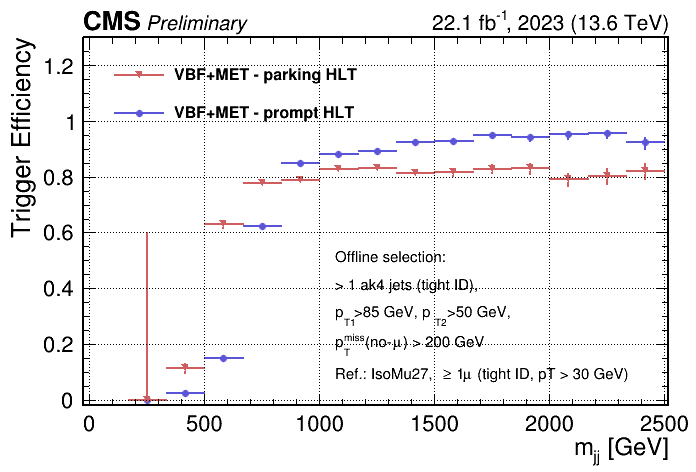

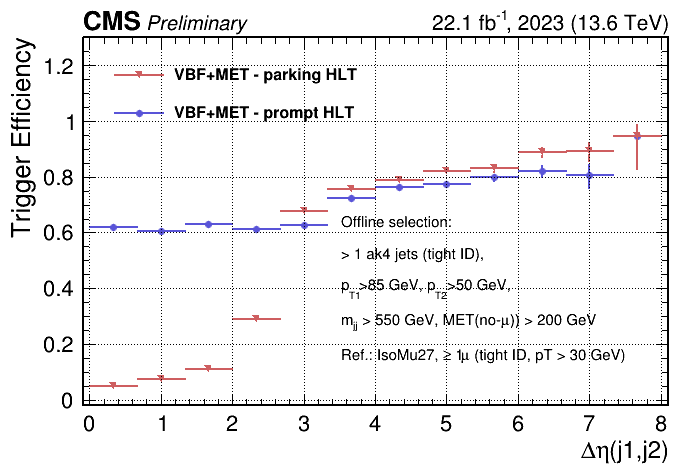

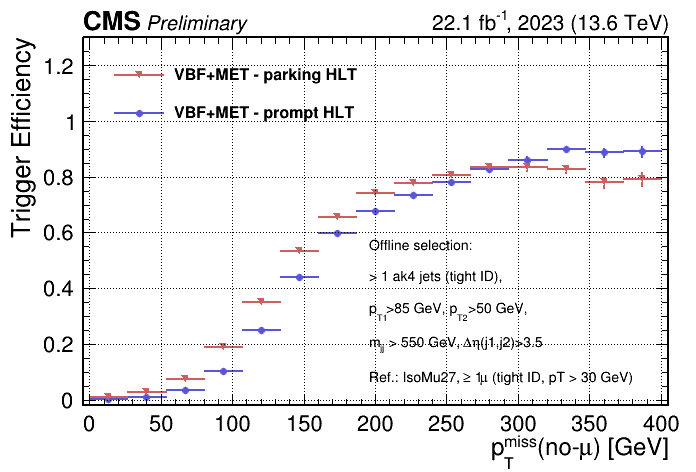

In [64]:
theYear = "23all"
for theVar in ['mjj','detajj','MET']:

#    Eff[theYear][theVar]['L1'].SetLineColor(8)
#    Eff[theYear][theVar]['L1'].SetMarkerColor(8)
#    Eff[theYear][theVar]['L1'].SetLineWidth(2)
#    Eff[theYear][theVar]['L1'].SetMarkerStyle(22)
    
    
    Eff[theYear][theVar]['new'].SetLineColor(46)
    Eff[theYear][theVar]['new'].SetMarkerColor(46)
    Eff[theYear][theVar]['new'].SetLineWidth(2)
    Eff[theYear][theVar]['new'].SetMarkerStyle(23)
    
    
    Eff[theYear][theVar]['old'].SetLineColor(9)
    Eff[theYear][theVar]['old'].SetMarkerColor(9)
    Eff[theYear][theVar]['old'].SetLineWidth(2)
    Eff[theYear][theVar]['old'].SetMarkerStyle(20)    
    
    
    path[theVar] = ROOT.TPaveText(text_coord[theVar][0],
                                  text_coord[theVar][1],
                                  text_coord[theVar][2],
                                  text_coord[theVar][3])
    #path[theVar] = ROOT.TPaveText(40,0.8,110,1.2)
    
    path[theVar].SetTextAlign(12)
    path[theVar].SetFillStyle(0)
    path[theVar].SetBorderSize(0)
    #        'Selection: 
    # #newline #geq 1 ak4 jets (tight ID), 
    # #newline p_{T1}>140 GeV, p_{T2}>70 GeV, 
    # #newline #Delta#eta(j1,j2)>3.5 #
    # #newline Ref.: IsoMu27, > 1 #mu (tight ID, pT > 30 GeV)',  
    
#    path[theVar].AddText("Path: {thepath}".format(thepath=TRIGLABEL['VBFmet']))
#    path[theVar].AddText("Path: {thepath}".format(thepath=TRIGLABEL['VBFincl']))
#    path[theVar].AddText("Path: {thepath}".format(thepath=TRIGLABEL['VBFmu']))
    path[theVar].AddText('Offline selection:')
    path[theVar].AddText('> 1 ak4 jets (tight ID), ')
    #path[theVar].AddText('p_{T1}>125 GeV, p_{T2}>50 GeV, ') 
    path[theVar].AddText('p_{T1}>85 GeV, p_{T2}>50 GeV, ') 
    path[theVar].AddText(add_cut_label[theVar])
    path[theVar].AddText('Ref.: IsoMu27, #geq 1#mu (tight ID, pT > 30 GeV) ')
    
    #path.AddText('#geq 1 b-tagged large radius (R=0.8) jets,')
    #path.AddText('p_{T}>250 GeV, m_{SD} > 40 GeV')  
    
    
    
#    legend[theVar] = ROOT.TLegend(0.65,0.75,0.90,0.90) # top right
    legend[theVar] = ROOT.TLegend(0.15,0.72,0.55,0.88) # top left
#    legend[theVar] = ROOT.TLegend(0.15,0.68,0.85,0.88) # top left extended
    legend[theVar].SetFillStyle(0)
    legend[theVar].SetBorderSize(0)
#    legend[theVar].SetHeader('HLT_VBF_DiPFJet75_40_Mjj500_Detajj2p5_PFMET85(_TriplePFJet)')
#    legend[theVar].AddEntry(Eff[theYear][theVar]['L1'],   'VBF+mu - L1','lp')
#    legend[theVar].AddEntry(Eff[theYear][theVar]['new'],  'VBF+mu - HLT','lp')
#    legend[theVar].AddEntry(Eff[theYear][theVar]['L1'],   'VBF inclusive - L1','lp')
#    legend[theVar].AddEntry(Eff[theYear][theVar]['new'],  'VBF inclusive - HLT','lp')
    #legend[theVar].AddEntry(Eff[theYear][theVar]['L1'],   'VBF+MET - L1','lp')
    legend[theVar].AddEntry(Eff[theYear][theVar]['new'],  'VBF+MET - parking HLT','lp')
    legend[theVar].AddEntry(Eff[theYear][theVar]['old'],  'VBF+MET - prompt HLT','lp')
    
    
    canvas[theVar]=ROOT.TCanvas(theVar,"Trigger Efficicency")
    canvas[theVar].SetFillColor(0)
    canvas[theVar].SetBorderMode(0)
    canvas[theVar].SetFrameFillStyle(0)
    canvas[theVar].SetFrameBorderMode(0)
    canvas[theVar].SetLeftMargin( L/W )
    canvas[theVar].SetRightMargin( R/W )
    canvas[theVar].SetTopMargin( T/H )
    canvas[theVar].SetBottomMargin( B/H )
    canvas[theVar].SetTickx()
    canvas[theVar].SetTicky()
    canvas[theVar].SetGrid()
    
    #canvas.Update()
    #canvas.RedrawAxis()
    
    #anvas.SetGrid()
    canvas[theVar].cd()
    
    #dummy hist for consistent display
    
    xlow=Eff[theYear][theVar]['L1'].GetXaxis().GetBinLowEdge(0)
    xhigh=Eff[theYear][theVar]['L1'].GetXaxis().GetBinUpEdge(92)
    hpx[theVar] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
    hpx[theVar].SetStats(False)
    
    hpx[theVar].SetTitle(theVar)
    hpx[theVar].GetXaxis().SetTitle(VARLABELS[theVar])
    hpx[theVar].GetYaxis().SetTitle("Trigger Efficiency")
    hpx[theVar].GetXaxis().SetTitleSize(0.055)
    hpx[theVar].GetXaxis().SetTitleOffset(1.1)
    hpx[theVar].GetYaxis().SetTitleSize(0.06)
    hpx[theVar].GetYaxis().SetTitleOffset(0.9)
    hpx[theVar].Draw()
        
    #Eff[theYear][theVar]['L1'].Draw("p same")
    Eff[theYear][theVar]['old'].Draw("p same")
    Eff[theYear][theVar]['new'].Draw("p same")
    legend[theVar].Draw("same")
    path[theVar].Draw("same")
    canvas[theVar].Update()
    CMS_lumi.CMS_lumi(canvas[theVar], iPeriod, iPos)
    redrawBorder()
    canvas[theVar].Draw()
    
    
    canvas[theVar].SaveAs("./DPSplots/prompt_vs_parking_VBFMET_{}.MC.pdf".format(theVar))
    canvas[theVar].SaveAs("./DPSplots/prompt_vs_parking_VBFMET_{}.MC.png".format(theVar))

In [59]:
os.system('pwd')

0

/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts


In [60]:
def draw_Eff_2year(thePath, theYear1,theYear2,theVar,theVersion):
    Eff[theYear1][theVar][theVersion].SetLineColor(46)
    Eff[theYear1][theVar][theVersion].SetMarkerColor(46)
    Eff[theYear1][theVar][theVersion].SetLineWidth(2)
    Eff[theYear1][theVar][theVersion].SetMarkerStyle(23)
    
    
    Eff[theYear2][theVar][theVersion].SetLineColor(9)
    Eff[theYear2][theVar][theVersion].SetMarkerColor(9)
    Eff[theYear2][theVar][theVersion].SetLineWidth(2)
    Eff[theYear2][theVar][theVersion].SetMarkerStyle(20)  
    
    path[theVar] = ROOT.TPaveText(text_coord[theVar][0],
                                  text_coord[theVar][1],
                                  text_coord[theVar][2],
                                  text_coord[theVar][3])
    
    path[theVar].SetTextAlign(12)
    path[theVar].SetFillStyle(0)
    path[theVar].SetBorderSize(0)
    
    path[theVar].AddText('Offline selection:')
    path[theVar].AddText('> 1 ak4 jets (tight ID), ')
    path[theVar].AddText('p_{T1}>85 GeV, p_{T2}>50 GeV, ') 
    path[theVar].AddText(add_cut_label[theVar])
    path[theVar].AddText('Ref.: IsoMu27, #geq 1#mu (tight ID, pT > 30 GeV) ')
    
    legend[theVar].SetFillStyle(0)
    legend[theVar].SetBorderSize(0)
    legend[theVar].AddEntry(Eff[theYear1][theVar][theVersion],  '{}- {}'.format(thePath,theYear1),'lp')
    legend[theVar].AddEntry(Eff[theYear2][theVar][theVersion],  '{}- {}'.format(thePath,theYear2),'lp')
    
    canvas[theVar]=ROOT.TCanvas(theVar,"Trigger Efficicency")
    canvas[theVar].SetFillColor(0)
    canvas[theVar].SetBorderMode(0)
    canvas[theVar].SetFrameFillStyle(0)
    canvas[theVar].SetFrameBorderMode(0)
    canvas[theVar].SetLeftMargin( L/W )
    canvas[theVar].SetRightMargin( R/W )
    canvas[theVar].SetTopMargin( T/H )
    canvas[theVar].SetBottomMargin( B/H )
    canvas[theVar].SetTickx()
    canvas[theVar].SetTicky()
    canvas[theVar].SetGrid()
    canvas[theVar].cd()
    
    xlow=Eff[theYear][theVar][theVersion].GetXaxis().GetBinLowEdge(0)
    xhigh=Eff[theYear][theVar][theVersion].GetXaxis().GetBinUpEdge(92)
    hpx[theVar] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
    hpx[theVar].SetStats(False)
    
    hpx[theVar].SetTitle(theVar)
    hpx[theVar].GetXaxis().SetTitle(VARLABELS[theVar])
    hpx[theVar].GetYaxis().SetTitle("Trigger Efficiency")
    hpx[theVar].GetXaxis().SetTitleSize(0.055)
    hpx[theVar].GetXaxis().SetTitleOffset(1.1)
    hpx[theVar].GetYaxis().SetTitleSize(0.06)
    hpx[theVar].GetYaxis().SetTitleOffset(0.9)
    hpx[theVar].Draw()
        
    #Eff[theYear][theVar]['L1'].Draw("p same")
    Eff[theYear1][theVar][theVersion].Draw("p same")
    Eff[theYear2][theVar][theVersion].Draw("p same")
    legend[theVar].Draw("same")
    path[theVar].Draw("same")
    canvas[theVar].Update()
    CMS_lumi.CMS_lumi(canvas[theVar], iPeriod, iPos)
    redrawBorder()
    canvas[theVar].Draw()

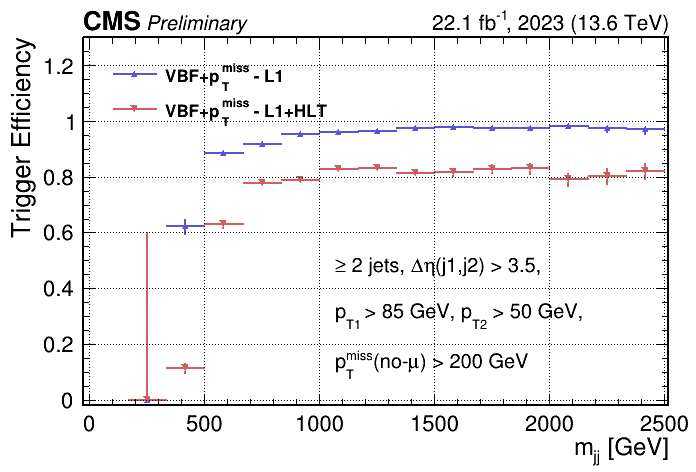

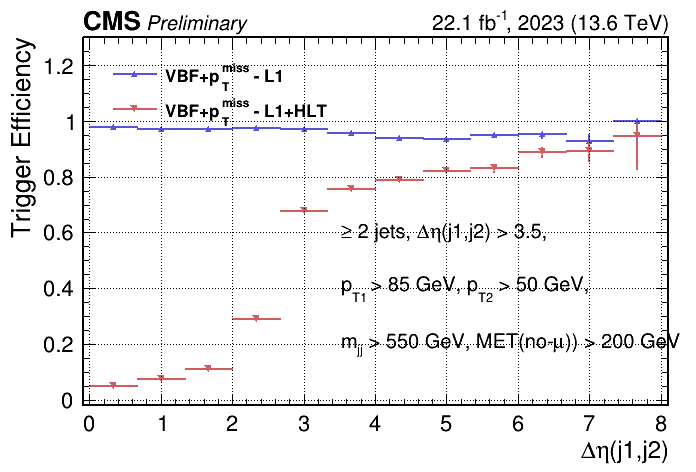

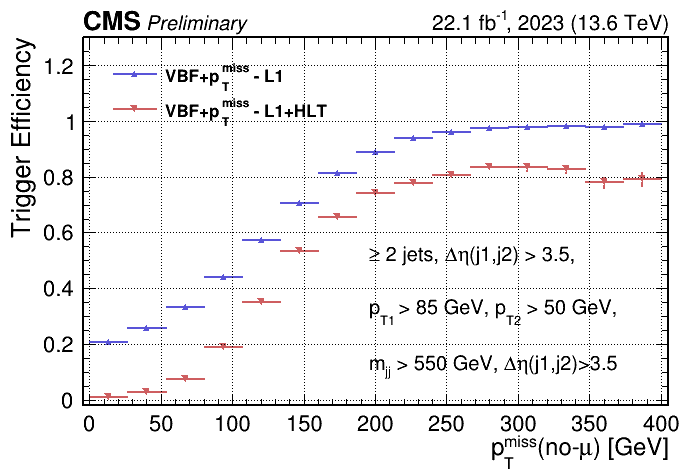

In [65]:
theYear = "23all"
for theVar in ['mjj','detajj','MET']:

#    Eff[theYear][theVar]['L1'].SetLineColor(8)
#    Eff[theYear][theVar]['L1'].SetMarkerColor(8)
#    Eff[theYear][theVar]['L1'].SetLineWidth(2)
#    Eff[theYear][theVar]['L1'].SetMarkerStyle(22)
    
    
#    Eff['23C'][theVar]['new'].SetLineColor(46)
#    Eff['23C'][theVar]['new'].SetMarkerColor(46)
#    Eff['23C'][theVar]['new'].SetLineWidth(2)
#    Eff['23C'][theVar]['new'].SetMarkerStyle(23)
#    
#    
#    Eff['23D'][theVar]['new'].SetLineColor(9)
#    Eff['23D'][theVar]['new'].SetMarkerColor(9)
#    Eff['23D'][theVar]['new'].SetLineWidth(2)
#    Eff['23D'][theVar]['new'].SetMarkerStyle(22)    
    
    
    Eff['23all'][theVar]['new'].SetLineColor(46)
    Eff['23all'][theVar]['new'].SetMarkerColor(46)
    Eff['23all'][theVar]['new'].SetLineWidth(2)
    Eff['23all'][theVar]['new'].SetMarkerStyle(23)   
    
    Eff['23all'][theVar]['L1'].SetLineColor(9)
    Eff['23all'][theVar]['L1'].SetMarkerColor(9)
    Eff['23all'][theVar]['L1'].SetLineWidth(2)
    Eff['23all'][theVar]['L1'].SetMarkerStyle(22)   
    
    path[theVar] = ROOT.TPaveText(text_coord[theVar][0],
                                  text_coord[theVar][1],
                                  text_coord[theVar][2],
                                  text_coord[theVar][3])
    
    path[theVar].SetTextAlign(12)
    path[theVar].SetFillStyle(0)
    path[theVar].SetBorderSize(0)

    #path[theVar].AddText('Offline selection:')
    path[theVar].AddText('#geq 2 jets, #Delta#eta(j1,j2) > 3.5,')
    path[theVar].AddText('p_{T1} > 85 GeV, p_{T2} > 50 GeV, ') 
    path[theVar].AddText(add_cut_label[theVar])
    #path[theVar].AddText('Ref.: IsoMu27, #geq 1#mu (tight ID, pT > 30 GeV) ')
    
    
    
#    legend[theVar] = ROOT.TLegend(0.65,0.75,0.90,0.90) # top right
    legend[theVar] = ROOT.TLegend(0.15,0.73,0.5,0.88) # top left
    legend[theVar].SetTextSize(0.04)
    legend[theVar].SetFillStyle(0)
    legend[theVar].SetBorderSize(0)
    legend[theVar].AddEntry(Eff['23all'][theVar]['L1'],  'VBF+p_{T}^{miss} - L1','lp')
    legend[theVar].AddEntry(Eff['23all'][theVar]['new'],  'VBF+p_{T}^{miss} - L1+HLT','lp')
    
    canvas[theVar]=ROOT.TCanvas(theVar,"Trigger Efficicency")
    canvas[theVar].SetFillColor(0)
    canvas[theVar].SetBorderMode(0)
    canvas[theVar].SetFrameFillStyle(0)
    canvas[theVar].SetFrameBorderMode(0)
    canvas[theVar].SetLeftMargin( L/W )
    canvas[theVar].SetRightMargin( R/W )
    canvas[theVar].SetTopMargin( T/H )
    canvas[theVar].SetBottomMargin( B/H )
    canvas[theVar].SetTickx()
    canvas[theVar].SetTicky()
    canvas[theVar].SetGrid()
    
    canvas[theVar].cd()
    
    #dummy hist for consistent display
    xlow=Eff[theYear][theVar]['L1'].GetXaxis().GetBinLowEdge(0)
    xhigh=Eff[theYear][theVar]['L1'].GetXaxis().GetBinUpEdge(92)
    hpx[theVar] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
    hpx[theVar].SetStats(False)
    
    hpx[theVar].SetTitle(theVar)
    hpx[theVar].GetXaxis().SetTitle(VARLABELS[theVar])
    hpx[theVar].GetYaxis().SetTitle("Trigger Efficiency")
    hpx[theVar].GetXaxis().SetTitleSize(0.055)
    hpx[theVar].GetXaxis().SetTitleOffset(1.1)
    hpx[theVar].GetYaxis().SetTitleSize(0.06)
    hpx[theVar].GetYaxis().SetTitleOffset(0.9)
    hpx[theVar].Draw()
    
    path[theVar].SetTextSize(0.045);
    
    Eff['23all'][theVar]['L1'].Draw("p same")
    Eff['23all'][theVar]['new'].Draw("p same")
    legend[theVar].Draw("same")
    path[theVar].Draw("same")
    canvas[theVar].Update()
    CMS_lumi.CMS_lumi(canvas[theVar], iPeriod, iPos)
    redrawBorder()
    canvas[theVar].Draw()
    
    canvas[theVar].SaveAs("./DPSplots/VBFMET_L1HLT_{}.forDPS.pdf".format(theVar))
    canvas[theVar].SaveAs("./DPSplots/VBFMET_L1HLT_{}.forDPS.png".format(theVar))
    canvas[theVar].SaveAs("./DPSplots/VBFMET_L1HLT_{}.forDPS.root".format(theVar))

In [ ]:
# TESTING PLOTS: VBF inclusive - L1 vs HLT efficiency
h_den   = df_mjj_den.Histo1D(    ('h_den','',   15,0,4000),'mjj2')
h_num   = df_mjj_num.Histo1D(    ('h_num','',   15,0,4000),'mjj2')
h_numL1 = df_mjj_numL1.Histo1D(  ('h_numL1','', 15,0,4000),'mjj2')
#h_den   = df_mjj_den.Histo1D(    ('h_den','',   15,0,400),'METnoMu')
#h_num   = df_mjj_num.Histo1D(    ('h_num','',   15,0,400),'METnoMu')
#h_numL1 = df_mjj_numL1.Histo1D(  ('h_numL1','', 15,0,400),'METnoMu')
#h_den   = df_mjj_den.Histo1D(    ('h_den','',   15,0,10),'Detajj')
#h_num   = df_mjj_num.Histo1D(    ('h_num','',   15,0,10),'Detajj')
#h_numL1 = df_mjj_numL1.Histo1D(  ('h_numL1','', 15,0,10),'Detajj')

print("den integral    = {}".format(h_den   .Integral()))
print("num integral    = {}".format(h_num   .Integral()))
print("numL1 integral  = {}".format(h_numL1 .Integral()))

EffHLT   = ROOT.TGraphAsymmErrors(h_num.GetValue(),  h_den.GetValue(), 'eff_mjj')
EffL1 = ROOT.TGraphAsymmErrors(h_numL1.GetValue(),h_den.GetValue(), 'eff_mjj')

c = ROOT.TCanvas()
c.SetGridx()
c.SetGridy()
c.SetTickx()
c.SetTicky()
EffHLT.GetYaxis().SetRangeUser(0.,1.3)
EffL1.GetYaxis().SetRangeUser(0.,1.3)
EffL1.GetYaxis().SetTitle('Trigger efficiency')
EffL1.GetXaxis().SetTitle('m_{jj} [GeV]')
EffL1.Draw('ap')
EffHLT.SetLineColor(2)
EffHLT.Draw('psame')
legend = ROOT.TLegend(0.5,0.15,0.9,0.5)
legend.SetFillStyle(0)
legend.SetBorderSize(0)
legend.AddEntry(EffL1,'VBFincl - L1','lp')
legend.AddEntry(EffHLT,  'VBFincl - HLT','lp')
legend.Draw("same")

c.Draw()

In [6]:
# Fill one DF per (variable to plot)x(trigger to check)
# only for VBF-jet variables for now (TODO: central objects)

dfs = {}
for trig in trigs:
    dfs[trig] = {}
    dfs[trig]['mjj'] = df.Filter(add_cut_str[trig]).Filter(cut_str['mjj'].format(detajjcut=jet_cuts[trig]['detajj'],
                                                pt1cut=jet_cuts[trig]['pt1'],
                                                pt2cut=jet_cuts[trig]['pt2']))
    
    dfs[trig]['pt1'] = df.Filter(add_cut_str[trig]).Filter(cut_str['pt1'].format(detajjcut=jet_cuts[trig]['detajj'],
                                                pt2cut=jet_cuts[trig]['pt2'],
                                                mjjcut=jet_cuts[trig]['mjj']))
    
    dfs[trig]['pt2'] = df.Filter(add_cut_str[trig]).Filter(cut_str['pt2'].format(detajjcut=jet_cuts[trig]['detajj'],
                                                pt1cut=jet_cuts[trig]['pt1'],
                                                pt2cut=jet_cuts[trig]['pt2'],
                                                mjjcut=jet_cuts[trig]['mjj']))
    
    dfs[trig]['detajj'] = df.Filter(add_cut_str[trig]).Filter(cut_str['detajj'].format(mjjcut=jet_cuts[trig]['mjj'],
                                                             pt1cut=jet_cuts[trig]['pt1'],
                                                             pt2cut=jet_cuts[trig]['pt2']))
    
    

In [7]:
h_den = {}
h_num = {}
Eff = {}
for trig in trigs:
    h_den[trig] = {}
    h_num[trig] = {}
    Eff[trig] = {}
    for var in jet_vars:
        h_num[trig][var] = dfs[trig][var].Filter('pass{trg}==1 && passSelec_{trg}==1'.format(trg=trig)).Histo1D(binning[var][0],var)
        h_den[trig][var] = dfs[trig][var].Filter('passSelec_{trg}==1'.format(trg=trig)).Histo1D(binning[var][1],var)
        Eff[trig][var] = ROOT.TGraphAsymmErrors(h_num[trig][var].GetValue(),h_den[trig][var].GetValue(),'eff_{}_{}'.format(trig,var))

x[0]=52, y[0]=0.129032, exl[0]=4, exh[0]=4, eyl[0]=0.042575, eyh[0]=0.042575
x[1]=60, y[1]=0.121951, exl[1]=4, exh[1]=4, eyl[1]=0.0255523, eyh[1]=0.0255523
x[2]=68, y[2]=0.109312, exl[2]=4, exh[2]=4, eyl[2]=0.019854, eyh[2]=0.019854
x[3]=76, y[3]=0.145669, exl[3]=4, exh[3]=4, eyl[3]=0.022135, eyh[3]=0.022135
x[4]=84, y[4]=0.118705, exl[4]=4, exh[4]=4, eyl[4]=0.0193987, eyh[4]=0.0193987
x[5]=92, y[5]=0.150579, exl[5]=4, exh[5]=4, eyl[5]=0.0222226, eyh[5]=0.0222226
x[6]=100, y[6]=0.310044, exl[6]=4, exh[6]=4, eyl[6]=0.0305636, eyh[6]=0.0305636
x[7]=108, y[7]=0.517094, exl[7]=4, exh[7]=4, eyl[7]=0.0326669, eyh[7]=0.0326669
x[8]=116, y[8]=0.709821, exl[8]=4, exh[8]=4, eyl[8]=0.0303238, eyh[8]=0.0303238
x[9]=124, y[9]=0.783251, exl[9]=4, exh[9]=4, eyl[9]=0.0289188, eyh[9]=0.0289188
x[10]=132, y[10]=0.812183, exl[10]=4, exh[10]=4, eyl[10]=0.0278267, eyh[10]=0.0278267
x[11]=140, y[11]=0.841808, exl[11]=4, exh[11]=4, eyl[11]=0.0274291, eyh[11]=0.0274291
x[12]=148, y[12]=0.85119, exl[12]=4, exh

In [8]:
def redrawBorder():
    ROOT.gPad.Update()
    ROOT.gPad.RedrawAxis()
    l = ROOT.TLine()
    l.SetLineWidth(2)
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymax())
    l.DrawLine(ROOT.gPad.GetUxmin(), ROOT.gPad.GetUymin(), ROOT.gPad.GetUxmax(), ROOT.gPad.GetUymin())

/grid_mnt/vol_home/llr/cms/portales/HIGtrigger/higgs-trigger-nanoaod/CMSSW_10_6_18/src/higgs-trigger-nanoaod/VBFparking_scripts/CMS_lumi.py


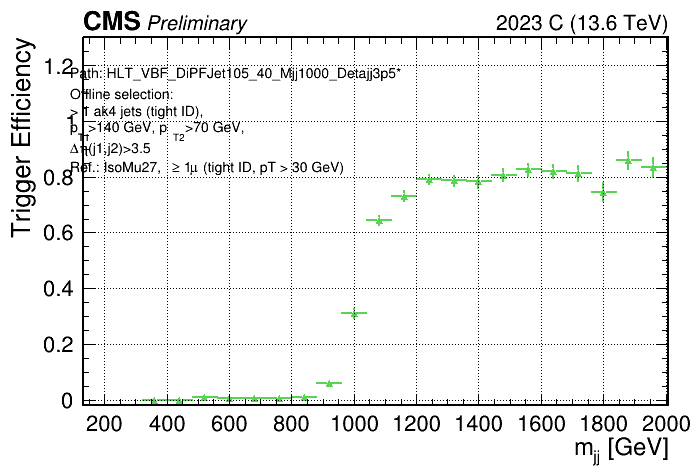

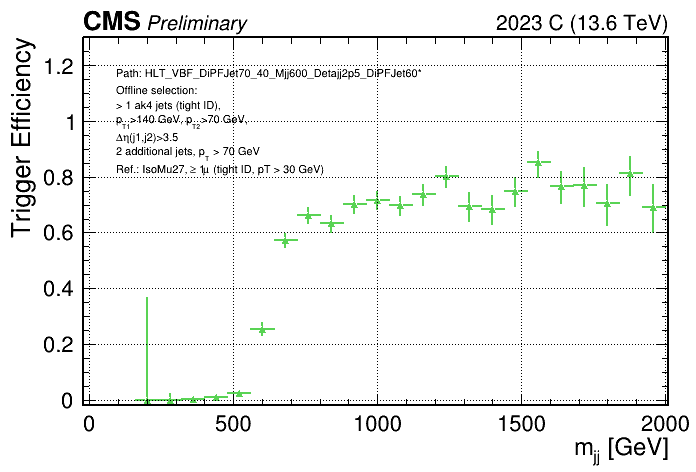

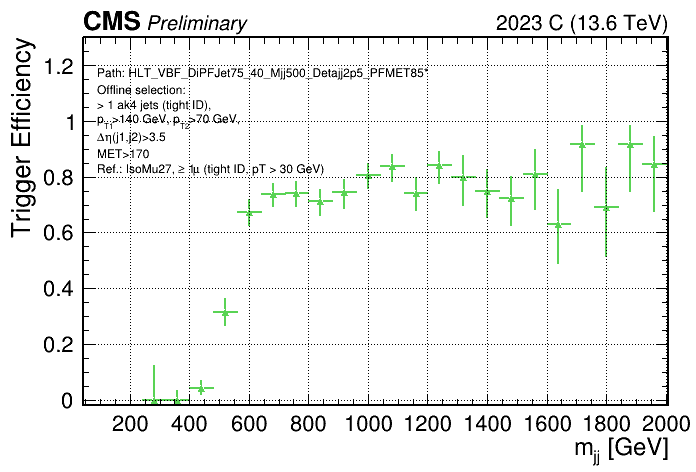

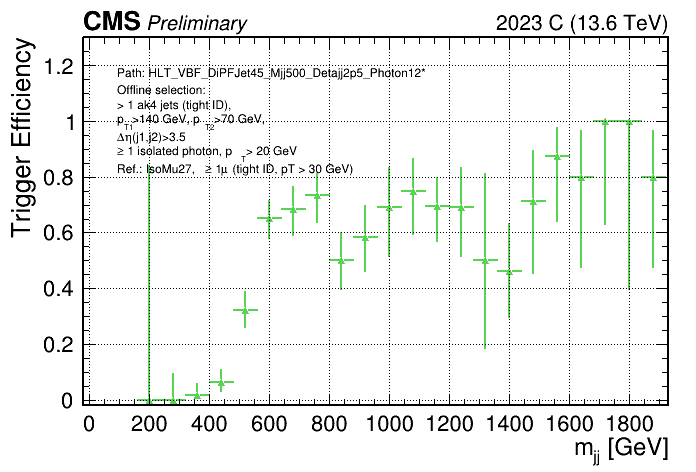

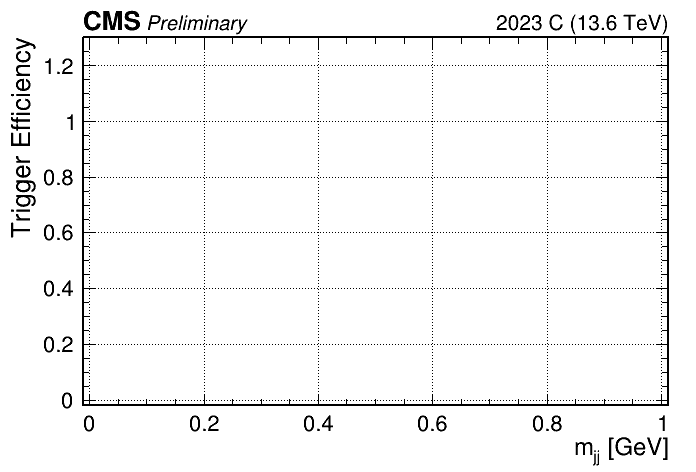

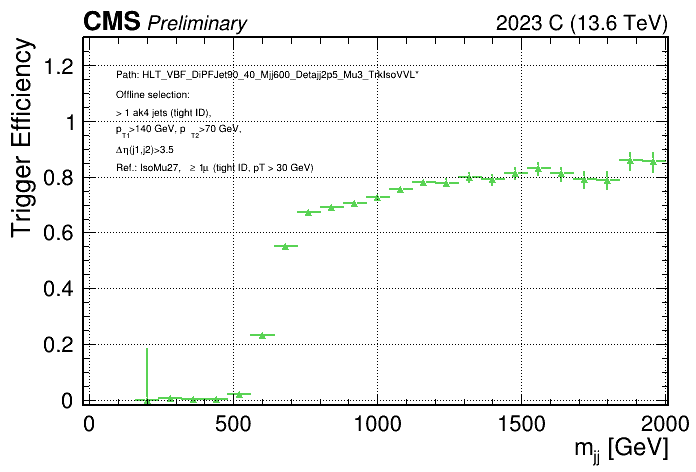

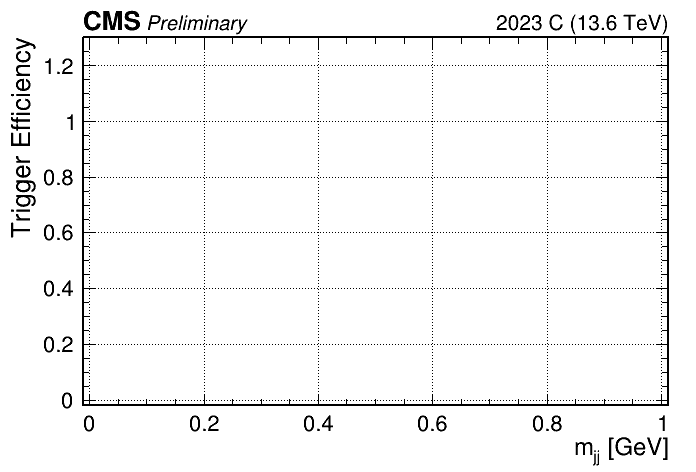

In [9]:
import CMS_lumi, tdrstyle
import array

print(CMS_lumi.__file__)

tdrstyle.setTDRStyle()

#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = True
CMS_lumi.extraText = "Preliminary"
CMS_lumi.lumi_sqrtS = "2023 C (13.6 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
iPeriod = 0

iPos = 0#11

H_ref = 600; 
W_ref = 800; 
W = W_ref
H  = H_ref

# references for T, B, L, R
T = 0.08*H_ref
B = 0.14*H_ref 
L = 0.12*W_ref
R = 0.04*W_ref


# Draw one plot for test
leg_x0 = 0.51
leg_y0 = 0.15
leg_x1 = 0.89
leg_y1 = 0.5

leg1_x0 = 0.15
leg1_y0 = 0.55
leg1_x1 = 0.49
leg1_y1 = 0.89

leg2_x0 = 0.15
leg2_y0 = 0.15
leg2_x1 = 0.49
leg2_y1 = 0.45

theVar = 'mjj'
theTrig = 'VBFmet'

path = {}
legend = {}
canvas = {}
hpx = {}
for theTrig in trigs:

    Eff[theTrig][theVar].SetLineColor(8)
    Eff[theTrig][theVar].SetMarkerColor(8)
    Eff[theTrig][theVar].SetLineWidth(2)
    Eff[theTrig][theVar].SetMarkerStyle(22)
    
    
    
    
    path[theTrig] = ROOT.TPaveText(30,0.8,1250,1.2)
    #path[theTrig] = ROOT.TPaveText(40,0.8,110,1.2)
    
    path[theTrig].SetTextAlign(12)
    path[theTrig].SetFillStyle(0)
    path[theTrig].SetBorderSize(0)
    #        'Selection: 
    # #newline #geq 1 ak4 jets (tight ID), 
    # #newline p_{T1}>140 GeV, p_{T2}>70 GeV, 
    # #newline #Delta#eta(j1,j2)>3.5 #
    # #newline Ref.: IsoMu27, > 1 #mu (tight ID, pT > 30 GeV)',  
    
    path[theTrig].AddText("Path: {thepath}".format(thepath=TRIGLABEL[theTrig]))
    path[theTrig].AddText('Offline selection:')
    path[theTrig].AddText('> 1 ak4 jets (tight ID), ')
    path[theTrig].AddText('p_{T1}>140 GeV, p_{T2}>70 GeV, ') 
    #path[theTrig].AddText('p_{T2}>70 GeV, m_{jj}>1200 GeV') 
    path[theTrig].AddText('#Delta#eta(j1,j2)>3.5 ')
    if theTrig in ['VBFjets','VBFmet','VBFphot']:
        path[theTrig].AddText(add_cut_label[theTrig])
    path[theTrig].AddText('Ref.: IsoMu27, #geq 1#mu (tight ID, pT > 30 GeV) ')
    
    #path.AddText('#geq 1 b-tagged large radius (R=0.8) jets,')
    #path.AddText('p_{T}>250 GeV, m_{SD} > 40 GeV')  
    
    
    
    
    #print(TRIG_INFO[theTrig]['path'])
    #path.SetFontSize(7)
    legend[theTrig] = ROOT.TLegend(0.16,0.65,0.4,0.9)
    legend[theTrig].SetFillStyle(0)
    legend[theTrig].SetBorderSize(0)
    canvas[theTrig]=ROOT.TCanvas(theTrig,"Trigger Efficicency")
    
    canvas[theTrig].SetFillColor(0)
    canvas[theTrig].SetBorderMode(0)
    canvas[theTrig].SetFrameFillStyle(0)
    canvas[theTrig].SetFrameBorderMode(0)
    canvas[theTrig].SetLeftMargin( L/W )
    canvas[theTrig].SetRightMargin( R/W )
    canvas[theTrig].SetTopMargin( T/H )
    canvas[theTrig].SetBottomMargin( B/H )
    canvas[theTrig].SetTickx()
    canvas[theTrig].SetTicky()
    canvas[theTrig].SetGrid()
    
    #canvas.Update()
    #canvas.RedrawAxis()
    
    #anvas.SetGrid()
    canvas[theTrig].cd()
    
    #dummy hist for consistent display
    
    xlow=Eff[theTrig][theVar].GetXaxis().GetBinLowEdge(0)
    xhigh=Eff[theTrig][theVar].GetXaxis().GetBinUpEdge(92)
    hpx[theTrig] = ROOT.TH2F("hpx","",10,xlow,xhigh,10,-0.02,1.3);
    hpx[theTrig].SetStats(False)
    
    hpx[theTrig].SetTitle(theTrig)
    hpx[theTrig].GetXaxis().SetTitle(VARLABELS[theVar])
    hpx[theTrig].GetYaxis().SetTitle("Trigger Efficiency")
    hpx[theTrig].GetXaxis().SetTitleSize(0.055)
    hpx[theTrig].GetXaxis().SetTitleOffset(1.1)
    hpx[theTrig].GetYaxis().SetTitleSize(0.06)
    hpx[theTrig].GetYaxis().SetTitleOffset(0.9)
    hpx[theTrig].Draw()
        
    Eff[theTrig][theVar].Draw("p same")
    legend[theTrig].Draw("same")
    path[theTrig].Draw("same")
    canvas[theTrig].Update()
    CMS_lumi.CMS_lumi(canvas[theTrig], iPeriod, iPos)
    redrawBorder()
    canvas[theTrig].Draw()